In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

In [24]:
vehicles = pd.read_csv("vehicles.csv")
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

### Clean data

In [25]:
#select useful columns and drop null values
data = vehicles[['region', 'price', 'year', 'manufacturer','model', 'condition', 'cylinders', 'fuel',
             'odometer', 'title_status','transmission', 'drive', 'size', 'type', 'paint_color','state','lat','long','posting_date']]
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86851 entries, 3 to 458211
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        86851 non-null  object 
 1   price         86851 non-null  int64  
 2   year          86851 non-null  float64
 3   manufacturer  86851 non-null  object 
 4   model         86851 non-null  object 
 5   condition     86851 non-null  object 
 6   cylinders     86851 non-null  object 
 7   fuel          86851 non-null  object 
 8   odometer      86851 non-null  float64
 9   title_status  86851 non-null  object 
 10  transmission  86851 non-null  object 
 11  drive         86851 non-null  object 
 12  size          86851 non-null  object 
 13  type          86851 non-null  object 
 14  paint_color   86851 non-null  object 
 15  state         86851 non-null  object 
 16  lat           86851 non-null  float64
 17  long          86851 non-null  float64
 18  posting_date  86851 non-n

In [26]:
data.shape

(86851, 19)

In [27]:
#convert data type
#convert 'year' and 'post_date' data type
data['year'] = data['year'].astype(int)
data['posting_date'] = pd.to_datetime(data['posting_date'], utc=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86851 entries, 3 to 458211
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   region        86851 non-null  object             
 1   price         86851 non-null  int64              
 2   year          86851 non-null  int64              
 3   manufacturer  86851 non-null  object             
 4   model         86851 non-null  object             
 5   condition     86851 non-null  object             
 6   cylinders     86851 non-null  object             
 7   fuel          86851 non-null  object             
 8   odometer      86851 non-null  float64            
 9   title_status  86851 non-null  object             
 10  transmission  86851 non-null  object             
 11  drive         86851 non-null  object             
 12  size          86851 non-null  object             
 13  type          86851 non-null  object             
 14  paint

In [28]:
#only analyze cars produced after 2000
data = data.loc[data.year>1999, :]
data['age'] = data.year.apply(lambda x: int(2021-x))
data.shape

(80747, 20)

### Descriptive analysis

#### The top manufacturers, types, models and colors

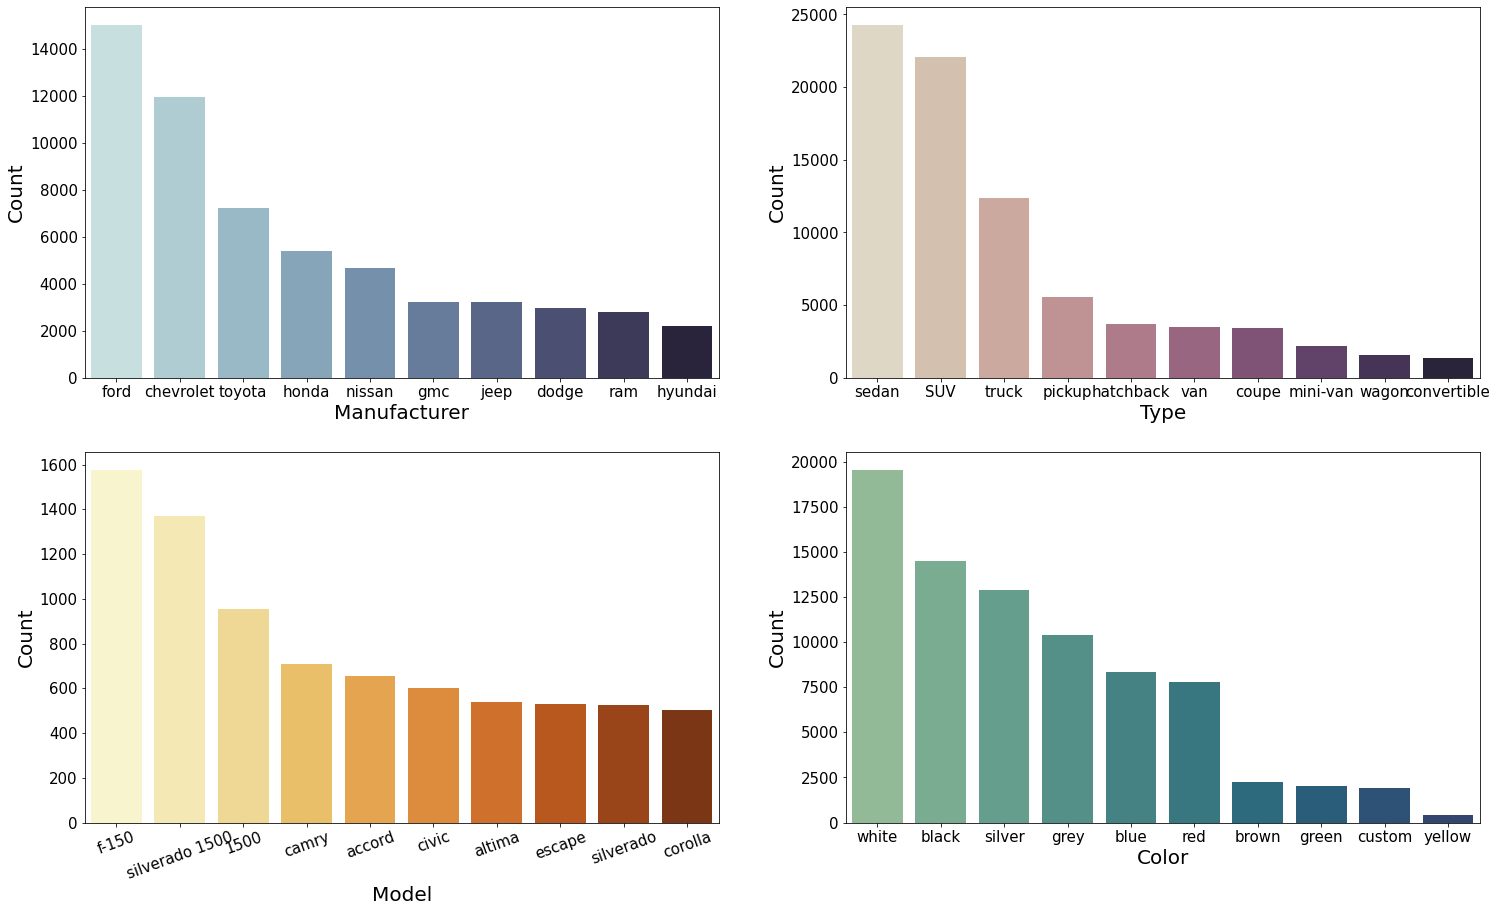

In [29]:
fig, ax =plt.subplots(2,2,figsize=(25, 15))
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.grid"] = False
a = sns.countplot(x ='manufacturer',data = data,order=data.manufacturer.value_counts().iloc[:10].index, 
              ax = ax[0][0],palette="ch:start=.2,rot=-.3")
a.set_xlabel("Manufacturer", fontsize = 20)
a.set_ylabel("Count", fontsize = 20)
a.tick_params(labelsize=15)

b = sns.countplot(x ='type',data = data,order=data.type.value_counts().iloc[:10].index, 
              ax = ax[0][1],palette="ch:s=-.2,r=.6")
b.set_xlabel("Type", fontsize = 20)
b.set_ylabel("Count", fontsize = 20)
b.tick_params(labelsize=15)

c = sns.countplot(x ='model',data = data,order=data.model.value_counts().iloc[:10].index, 
              ax = ax[1][0],palette="YlOrBr")
c.set_xlabel("Model", fontsize = 20)
c.set_ylabel("Count", fontsize = 20)
c.tick_params(labelsize=15)
c.set_xticklabels(c.get_xticklabels(),rotation=20)

d = sns.countplot(x ='paint_color',data = data,order=data.paint_color.value_counts().iloc[:10].index, 
              ax = ax[1][1],palette="crest")
d.set_xlabel("Color", fontsize = 20)
d.set_ylabel("Count", fontsize = 20)
d.tick_params(labelsize=15);

#### The distribution of the age of the used cars

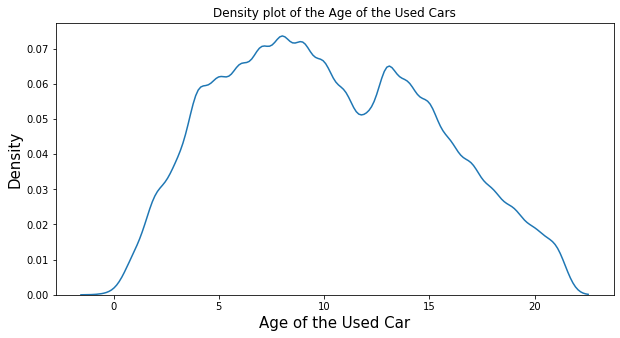

In [31]:
# age distribution
plt.figure(figsize=(10,5))
plt.rcParams["axes.labelsize"] = 15
plt.title("Density plot of the Age of the Used Cars")
plt.xlabel("Age of the Used Car")
stat = sns.kdeplot(data.age)

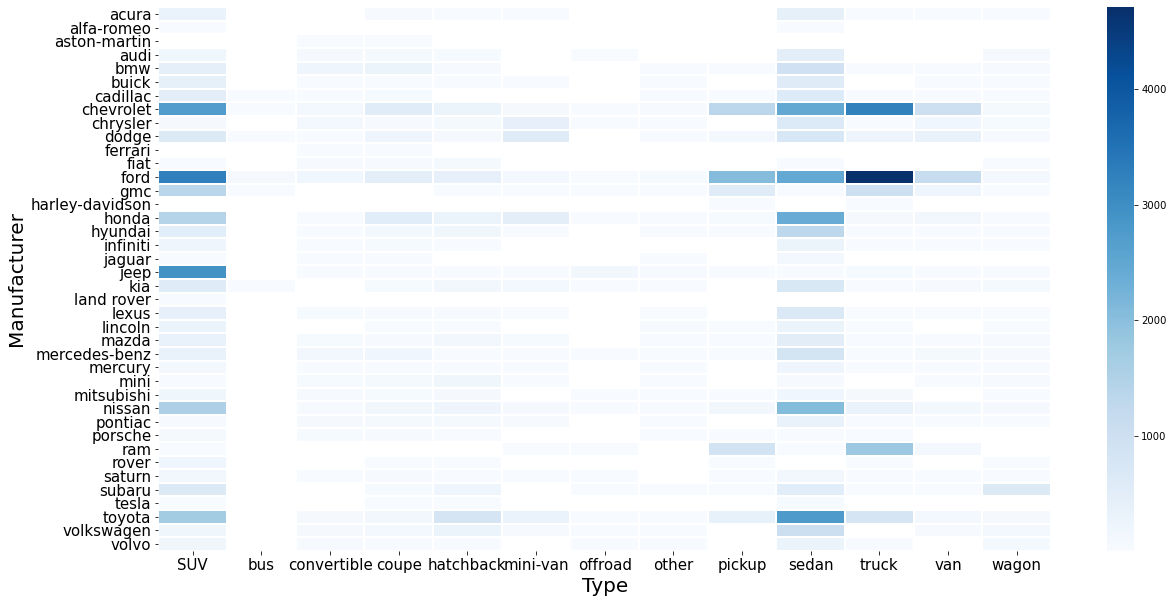

In [32]:
# Types of used cars from different manufacturers for sale

manu_type = data.groupby('manufacturer').type.value_counts()
manu_type_df = pd.DataFrame(manu_type.unstack())

plt.subplots(figsize=(20, 10))
h1 = sns.heatmap(manu_type_df, cmap='Blues', linecolor='white', linewidth=1)
h1.set_xlabel("Type", fontsize = 20)
h1.set_ylabel("Manufacturer", fontsize = 20)
h1.tick_params(labelsize=15);

#### Manufacturer with most used cars for sale each year

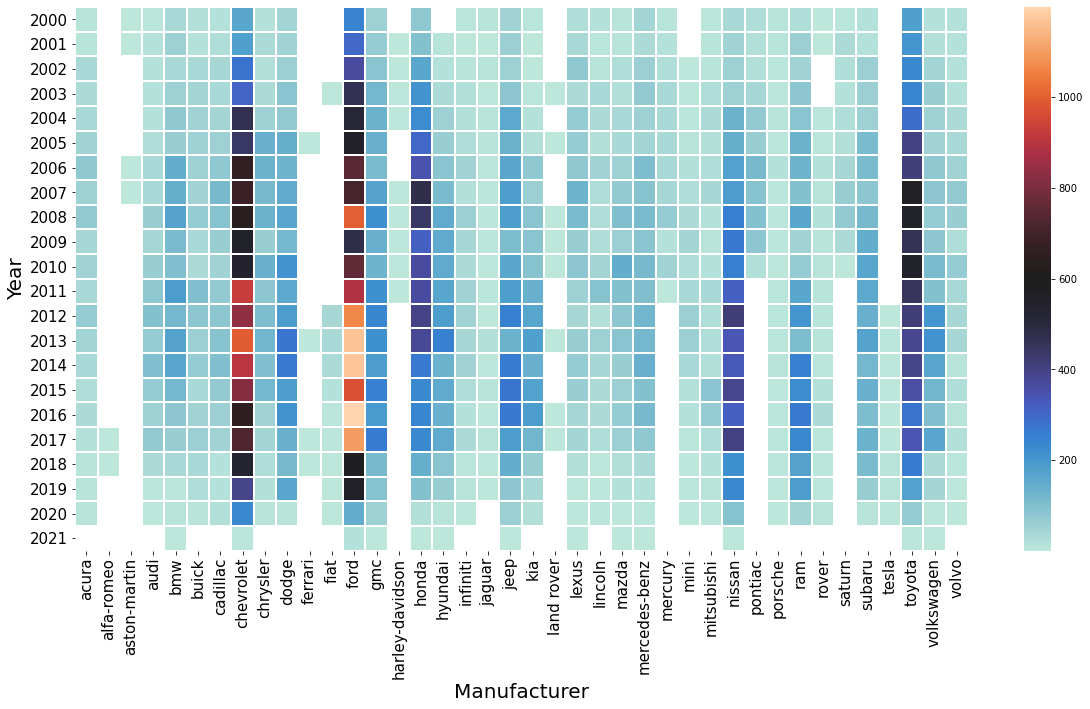

In [33]:
manf_sale_year = data.groupby('year').manufacturer.value_counts()
manf_sale_year_df = pd.DataFrame(manf_sale_year.unstack())

plt.subplots(figsize=(20, 10))
h2 = sns.heatmap(manf_sale_year_df, cmap='icefire', linecolor='white', linewidth=1)
h2.set_xlabel("Manufacturer", fontsize = 20)
h2.set_ylabel("Year", fontsize = 20)
h2.tick_params(labelsize=15);

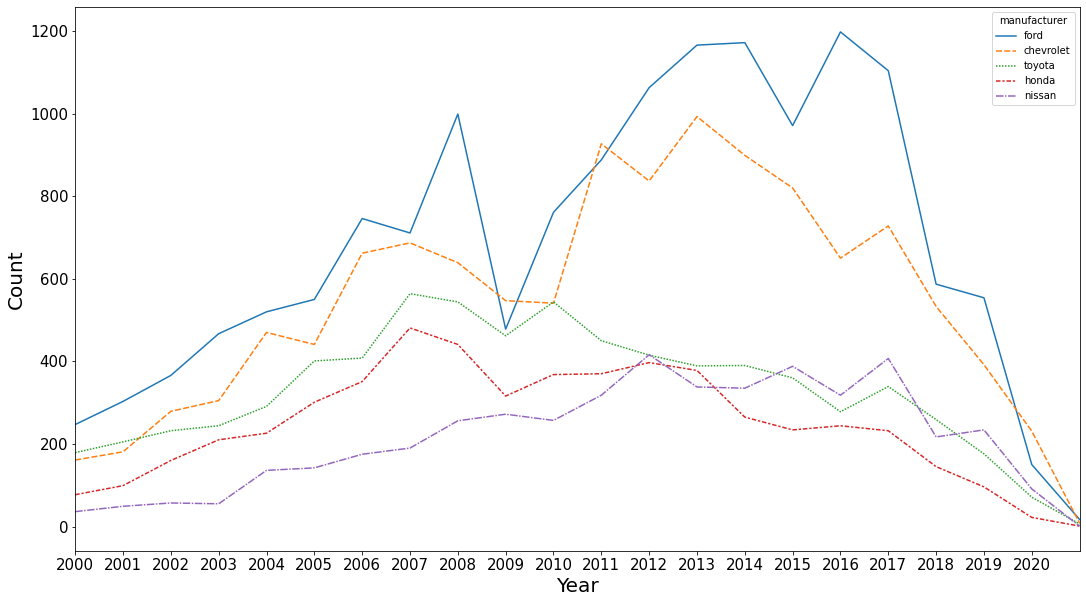

In [34]:
# Time series for for-sale used cars of top 5 manufacurers each year
manf_sale_year_df2 = manf_sale_year_df[['ford','chevrolet','toyota','honda','nissan']].copy()
fig, ax = plt.subplots(figsize=(18, 10))
m = sns.lineplot(data=manf_sale_year_df2)
ax.set_xlim(2000,2021)
ax.set_xticks(range(2000,2021))
m.set_xlabel("Year", fontsize = 20)
m.set_ylabel("Count", fontsize = 20)
m.tick_params(labelsize=15)
plt.show()

#### The posted price of the used cars

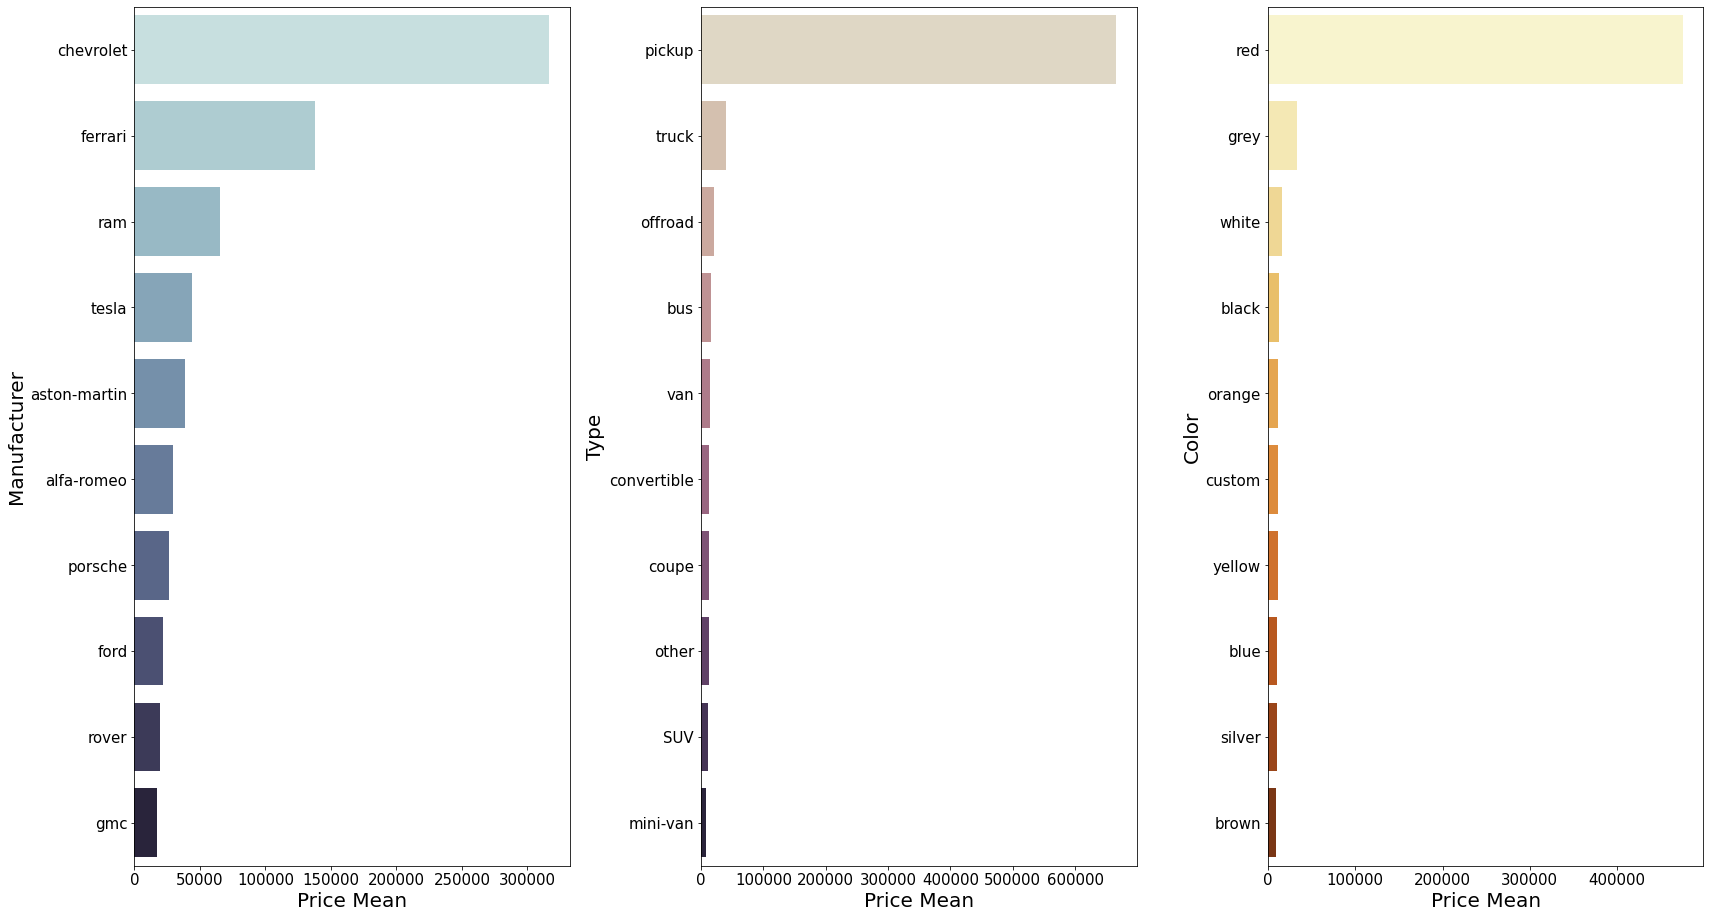

In [35]:
#price mean
price_mean_manu = data[['price','manufacturer']].groupby('manufacturer').mean().sort_values(by=['price'], ascending=False)
price_mean_type = data[['price','type']].groupby('type').mean().sort_values(by=['price'], ascending=False)
price_mean_color = data[['price','paint_color']].groupby('paint_color').mean().sort_values(by=['price'], ascending=False)


fig, ax =plt.subplots(1,3,figsize=(25, 15))
fig.tight_layout(pad=10)
ap = sns.barplot(x = 'price',y = price_mean_manu.index[:10],data=price_mean_manu.iloc[:10], 
              ax = ax[0],palette="ch:start=.2,rot=-.3")
ap.set_xlabel("Price Mean", fontsize = 20)
ap.set_ylabel("Manufacturer", fontsize = 20)
ap.tick_params(labelsize=15)

bp = sns.barplot(x = 'price',y = price_mean_type.index[:10],data=price_mean_type.iloc[:10], 
              ax = ax[1],palette="ch:s=-.2,r=.6")
bp.set_xlabel("Price Mean", fontsize = 20)
bp.set_ylabel("Type", fontsize = 20)
bp.tick_params(labelsize=15)

cp = sns.barplot(x = 'price',y = price_mean_color.index[:10],data=price_mean_color.iloc[:10], 
              ax = ax[2],palette="YlOrBr")
cp.set_xlabel("Price Mean", fontsize = 20)
cp.set_ylabel("Color", fontsize = 20)
cp.tick_params(labelsize=15);

#### The region comparison of the for-sale used cars

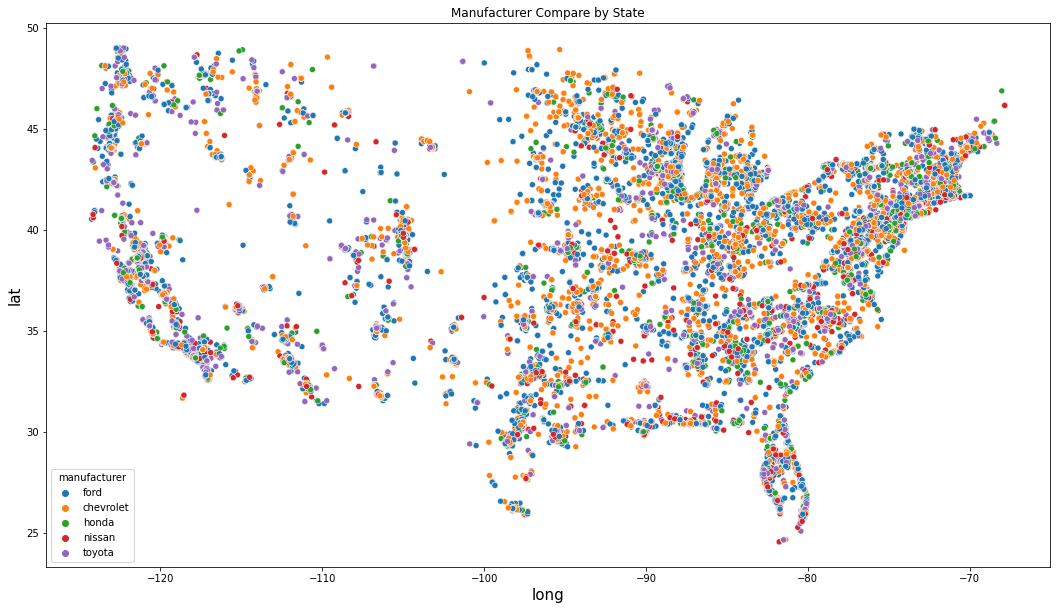

In [36]:
location = data[(data['lat']>24) & (data['lat']<50) & (data['long']>-125) & (data['long']<-65)]
manu_loc = location[(location['manufacturer']=='ford') | 
                (location['manufacturer']=='chevrolet')| 
                (location['manufacturer']=='toyota')| 
                (location['manufacturer']=='honda')| 
                (location['manufacturer']=='nissan')]
plt.figure(figsize=(18,10))
plt.title('Manufacturer Compare by State')
sns.scatterplot(data=manu_loc, x="long",y="lat",hue='manufacturer')
plt.show()

### Correlation analysis

#### Using Pearson Correlation

In [ ]:
vehicles.info()

In [ ]:
vehicles.drop(['id', 'url','region_url', 'VIN', 'image_url', 'lat', 'long', 'description'], axis=1, inplace=True)
print(vehicles.isnull().sum())

In [ ]:
# sorting columns based on their total null
null_val = pd.DataFrame(vehicles.isnull().sum(), columns = ['Nan_sum'])
null_val = null_val[null_val['Nan_sum']>0]
null_val['Percentage'] = (null_val['Nan_sum']/len(vehicles))*100
null_val = null_val.sort_values(by=['Nan_sum'], ascending=False)
null_val

We can treat those columns whose null values differently depends on the project's goal. For the sake of this project, we are only going to keep columns which have less than 40% of missing values.

In [ ]:
vehicles_cleaned = vehicles[['cylinders','paint_color','drive','type','odometer','manufacturer','model','fuel','title_status','transmission','year','posting_date']]
vehicles_cleaned.shape

we will drop all rows with missing values.

In [ ]:
vehicles_data = vehicles_cleaned.dropna()
vehicles_data